In [1]:
import os
import itertools
#hi
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import yaml
from joblib import Parallel, delayed
from sklearn import metrics
from aequitas.group import Group

from autodefer.models import haic
from autodefer.utils import thresholding as t, plotting
import pickle

import json

sns.set_style('whitegrid')

MODELS_PATH = './models/'

cfg_path = 'cfg.yaml'
with open(cfg_path, 'r') as infile:
    cfg = yaml.safe_load(infile)


data_cfg_path = '../data/dataset_cfg.yaml'

with open(data_cfg_path, 'r') as infile:
    data_cfg = yaml.safe_load(infile)


cat_dict = data_cfg['categorical_dict']

LABEL_COL = 'fraud_label'
PROTECTED_COL = 'customer_age'
CATEGORICAL_COLS = ['payment_type', 'employment_status', 'housing_status', 'source', 'device_os', 'assignment']
TIMESTAMP_COL = 'month'
SCORE_COL = 'model_score'
BATCH_COL = 'batch'
ASSIGNMENT_COL = 'assignment'
DECISION_COL = 'decision'


expert_ids_path = '../experts/expert_info/expert_ids.yaml'

with open(expert_ids_path, 'r') as infile:
    EXPERT_IDS = yaml.safe_load(infile)

test


# Expert behavior model performance

In [2]:
RMAs = dict()

for train_env in os.listdir(MODELS_PATH):
    RMAs[train_env] = haic.assigners.RiskMinimizingAssigner(
        expert_ids=EXPERT_IDS,
        outputs_dir=f'{MODELS_PATH}{train_env}/human_expertise_model/',
    )
    calibrator_path = f'{MODELS_PATH}{train_env}/calibrator.pickle'
    RMAs[train_env].load(CATEGORICAL_COLS, SCORE_COL, ASSIGNMENT_COL, calibrator_path, cat_dict)

In [3]:
test = pd.read_parquet('../testbed/test/test.parquet')
test_expert_pred = pd.read_parquet('../testbed/test/test_expert_pred.parquet')

def cat_checker(data, features, cat_dict):
    new_data = data.copy()
    for feature in features:
        if new_data[feature].dtype != 'category':
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
        elif new_data[feature].dtype.categories.to_list() != cat_dict[feature]:
            new_data[feature] = pd.Categorical(new_data[feature].values, categories=cat_dict[feature])
    
    return new_data


cat_dict['assignment'] = EXPERT_IDS['human_ids'] + EXPERT_IDS['model_ids']

test = cat_checker(test, data_cfg['data_cols']['categorical'], cat_dict)

def get_outcome(label, pred):
    if pred == 1:
        if label == 1:
            o = 'tp'
        elif label == 0:
            o = 'fp'
    elif pred == 0:
        if label == 1:
            o = 'fn'
        elif label == 0:
            o = 'tn'
    return o

test['assignment'] = 'blank'


test = test.drop(columns = ['fraud_label', 'month'])
roc_curves = dict()
outcome_df_test = pd.read_parquet('/mnt/home/jean.alves/Assign_Better/experts/expert_info/test_outcome.parquet')
if os.path.isfile('roc_curves.pkl'):
    with open('roc_curves.pkl', 'rb') as fp:
        roc_curves = pickle.load(fp)
else:
    for env_id in os.listdir(MODELS_PATH):
        print(env_id)
        curves = dict()
        total_outcomes = []
        total_pred_proba = []
        i=0
        for expert in EXPERT_IDS['human_ids']:
            model = RMAs[env_id]

            outcomes = outcome_df_test[expert]

            total_outcomes.append(outcomes.to_numpy().squeeze())

            test['assignment'] = expert
            
            test = cat_checker(test, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

            pred_proba = model.expert_model.predict_proba(test)
            total_pred_proba.append(pred_proba)

            fp_fpr, fp_tpr,_ = metrics.roc_curve(y_true = (outcomes == 'fp').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze())
            fn_fpr, fn_tpr,_ = metrics.roc_curve(y_true = (outcomes == 'fn').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze())
            fn_auc = metrics.roc_auc_score(y_true = (outcomes == 'fn').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze())
            fp_auc = metrics.roc_auc_score(y_true = (outcomes == 'fp').astype(int), y_score = pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze())
            curves[expert]= {'fp_fpr': fp_fpr,
                            'fp_tpr': fp_tpr,
                            'fn_fpr': fn_fpr,
                            'fn_tpr': fn_tpr,
                            'fn_auc': fn_auc,
                            'fp_auc': fp_auc,
                            'pred_proba': pred_proba,
                            }
            i+=1
            
        
        total_pred_proba = np.concatenate(total_pred_proba)
        total_outcomes = np.concatenate(total_outcomes)
        fp_fpr, fp_tpr,_ = metrics.roc_curve(y_true = (total_outcomes == 'fp').astype(int), y_score = total_pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze())
        fn_fpr, fn_tpr,_ = metrics.roc_curve(y_true = (total_outcomes == 'fn').astype(int), y_score = total_pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze())
        fn_auc = metrics.roc_auc_score(y_true = (total_outcomes == 'fn').astype(int), y_score = total_pred_proba[:, model.expert_model.classes_ == 'fn'].squeeze())
        fp_auc = metrics.roc_auc_score(y_true = (total_outcomes == 'fp').astype(int), y_score = total_pred_proba[:, model.expert_model.classes_ == 'fp'].squeeze())
        curves['all']= {'fp_fpr': fp_fpr,
                            'fp_tpr': fp_tpr,
                            'fn_fpr': fn_fpr,
                            'fn_tpr': fn_tpr,
                            'fn_auc': fn_auc,
                            'fp_auc': fp_auc,
                            'total_pred_proba': total_pred_proba,
                            'total_outcomes': total_outcomes
                            }
        roc_curves[env_id] = curves
    with open('roc_curves.pkl', 'wb') as fp:
        pickle.dump(roc_curves, fp)
        


small_regular
small_regular_old


In [5]:
pal = sns.color_palette(['C0','C2', 'C3'])
pal = pal.as_hex()

dict_keys(['small_regular', 'small_regular_old'])


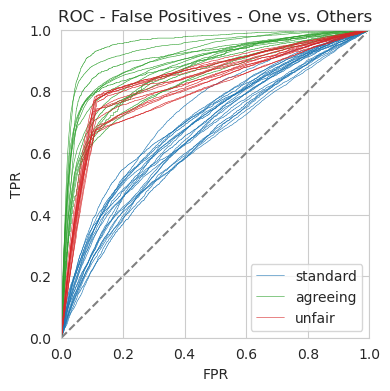

In [6]:


f, ax = plt.subplots(figsize=(4, 4))

print(roc_curves.keys())
train_env = 'small_regular'
exp = roc_curves[train_env]


reg_counter = 0
ma_counter = 0
un_counter = 0
for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'regular':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    plt.plot(exp[expert]['fp_fpr'],exp[expert]['fp_tpr'], c = color, linewidth = 0.4, label = setlabel)


plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Positives - One vs. Others')
plt.legend()
plt.savefig("ROC_FP_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

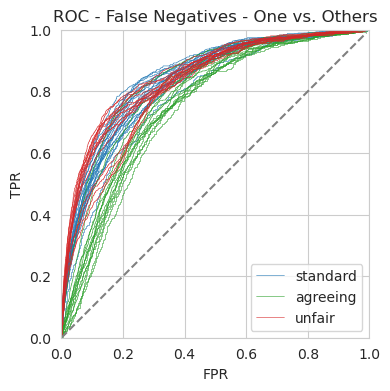

In [7]:
f, ax = plt.subplots(figsize=(4, 4))

exp = roc_curves['small_regular']

reg_counter = 0
ma_counter = 0
un_counter = 0

for expert in EXPERT_IDS['human_ids']:
    setlabel = None
    if expert.split('#')[0] == 'regular':
        color = pal[0]
        if(reg_counter == 0):
            setlabel = 'standard'
            reg_counter +=1
    elif expert.split('#')[0] == 'model_agreeing':
        color = pal[1]
        if(ma_counter == 0):
            setlabel = 'agreeing'
            ma_counter+=1
    elif expert.split('#')[0] == 'unfair':
        color = pal[2]
        if(un_counter == 0):
            setlabel = 'unfair'
            un_counter += 1
    plt.plot(exp[expert]['fn_fpr'],exp[expert]['fn_tpr'], c = color, linewidth = 0.4, label = setlabel)

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title(f'ROC - False Negatives - One vs. Others')
plt.legend()
plt.savefig("ROC_FN_OvO.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [8]:
import pandas as pd
from sklearn.isotonic import IsotonicRegression
test_pred = pd.read_parquet('../experts/expert_info/deployment_predictions.parquet')
val = pd.read_parquet('../data/BAF.parquet')
model_auc = RMAs['small_regular']
model_ce = RMAs['small_regular_old']

test = pd.read_parquet('../testbed/test/test.parquet')
test = test.drop(columns = 'month')

test_expert_pred = test_pred.loc[test.index]
test['model_score'] = test_expert_pred['model#0']


predicted_fp_ce = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
predicted_fn_ce = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])

predicted_fp_auc = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
predicted_fn_auc = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])

label_fp = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])
label_fn = pd.DataFrame(index = test.index, columns = EXPERT_IDS['human_ids'])

for expert in EXPERT_IDS['human_ids']:
    test['assignment'] = expert 
    test = cat_checker(test, data_cfg['data_cols']['categorical'] + ['assignment'], cat_dict)

    outcomes = pd.DataFrame()
    outcomes['labels'] = test['fraud_label']
    outcomes['decisions'] = test_expert_pred[expert]
    outcomes['outcomes'] = outcomes.apply(lambda x:    get_outcome(label=x['labels'], pred=x['decisions']),
                    axis=1,
            )
    
    pred_proba_auc = model_auc.expert_model.predict_proba(test.drop(columns = 'fraud_label'))
    pred_proba_ce = model_ce.expert_model.predict_proba(test.drop(columns = 'fraud_label'))

    label_fp[expert]=(outcomes['outcomes'] == 'fp').astype(int)
    label_fn[expert]=(outcomes['outcomes'] == 'fn').astype(int)

    predicted_fp_ce[expert]=pred_proba_ce[:, model_auc.expert_model.classes_ == 'fp'].squeeze()
    predicted_fn_ce[expert]=pred_proba_ce[:, model_auc.expert_model.classes_ == 'fn'].squeeze()

    predicted_fp_auc[expert]=pred_proba_auc[:, model_auc.expert_model.classes_ == 'fp'].squeeze()
    predicted_fn_auc[expert]=pred_proba_auc[:, model_auc.expert_model.classes_ == 'fn'].squeeze()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


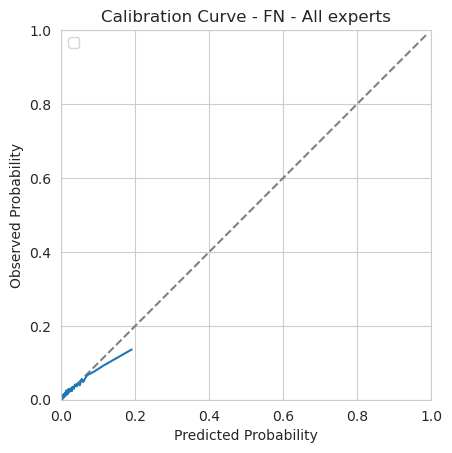

In [29]:
save_calib = dict()
from sklearn.calibration import calibration_curve
gb_y_ce, gb_x_ce = calibration_curve(label_fn.melt()['value'], predicted_fn_ce.melt()['value'], n_bins=1000, strategy='quantile')
gb_y_auc, gb_x_auc = calibration_curve(label_fn.melt()['value'], predicted_fn_auc.melt()['value'], n_bins=1000, strategy='quantile')

save_calib['fn_y_auc'] = gb_y_auc
save_calib['fn_x_auc'] = gb_x_auc

save_calib['fn_y_ce'] = gb_y_ce
save_calib['fn_x_ce'] = gb_x_ce

pal = sns.color_palette(['C0','C2', 'C3'])
pal = pal.as_hex()

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
# plot model reliability
plt.plot(gb_x_auc, gb_y_auc, marker='')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Curve - FN - All experts')
plt.savefig("Cal_FN.pdf", format="pdf", bbox_inches="tight")
plt.legend()
plt.show()

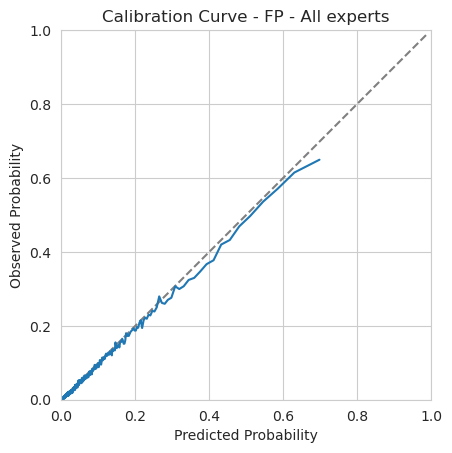

In [30]:
gb_y_ce, gb_x_ce = calibration_curve(label_fp.melt()['value'], predicted_fp_ce.melt()['value'], n_bins=1000, strategy='quantile')
gb_y_auc, gb_x_auc = calibration_curve(label_fp.melt()['value'], predicted_fp_auc.melt()['value'], n_bins=1000, strategy='quantile')

save_calib['fp_y_auc'] = gb_y_auc
save_calib['fp_x_auc'] = gb_x_auc

save_calib['fp_y_ce'] = gb_y_ce
save_calib['fp_x_ce'] = gb_x_ce

plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
# plot model reliability
plt.plot(gb_x_auc, gb_y_auc, marker='', color = pal[0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Curve - FP - All experts')
plt.savefig("Cal_FP.pdf", format="pdf", bbox_inches="tight")
plt.show()

with open('savecalib.pkl', 'wb') as fp:
    pickle.dump(save_calib, fp)
        

In [31]:
calib_individual = dict()

for expert in EXPERT_IDS['human_ids']:
    calib_individual[expert] = dict()
    gb_y, gb_x = calibration_curve(label_fp[expert], predicted_fp_auc[expert], n_bins=30, strategy='quantile')
    
    calib_individual[expert]['fp_y_auc'] = gb_y
    calib_individual[expert]['fp_x_auc'] = gb_x
    
    gb_y, gb_x = calibration_curve(label_fn[expert], predicted_fn_auc[expert], n_bins=30, strategy='quantile')

    calib_individual[expert]['fn_y_auc'] = gb_y
    calib_individual[expert]['fn_x_auc'] = gb_x

"""ASSIGNMENT_COL
for expert in EXPERT_IDS['human_ids']:
    calib_individual[expert] = dict()
    gb_y, gb_x = calibration_curve(label_fp[expert], predicted_fp_ce[expert], n_bins=30, strategy='quantile')
    
    calib_individual[expert]['fp_y_ce'] = gb_y
    calib_individual[expert]['fp_x_ce'] = gb_x
    
    gb_y, gb_x = calibration_curve(label_fn[expert], predicted_fn_ce[expert], n_bins=30, strategy='quantile')

    calib_individual[expert]['fn_y_ce'] = gb_y
    calib_individual[expert]['fn_x_ce'] = gb_x
"""


"ASSIGNMENT_COL\nfor expert in EXPERT_IDS['human_ids']:\n    calib_individual[expert] = dict()\n    gb_y, gb_x = calibration_curve(label_fp[expert], predicted_fp_ce[expert], n_bins=30, strategy='quantile')\n    \n    calib_individual[expert]['fp_y_ce'] = gb_y\n    calib_individual[expert]['fp_x_ce'] = gb_x\n    \n    gb_y, gb_x = calibration_curve(label_fn[expert], predicted_fn_ce[expert], n_bins=30, strategy='quantile')\n\n    calib_individual[expert]['fn_y_ce'] = gb_y\n    calib_individual[expert]['fn_x_ce'] = gb_x\n"

In [32]:
with open('savecalib_indiv.pkl', 'wb') as fp:
    pickle.dump(calib_individual, fp)
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


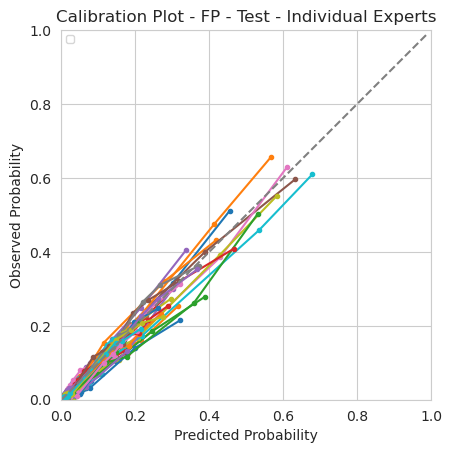

In [24]:
for expert in EXPERT_IDS['human_ids']:
        plt.plot(calib_individual[expert]['fp_x_auc'], calib_individual[expert]['fp_y_auc'], marker = '.')
plt.xlim(0, 1)
plt.plot(np.arange(0,1,0.01), np.arange(0,1,0.01), c = 'gray', linestyle = 'dashed')
plt.ylim(0, 1)
plt.gca().set_aspect('equal')
plt.xlabel('Predicted Probability')
plt.ylabel('Observed Probability')
plt.title(f'Calibration Plot - FP - Test - Individual Experts')
plt.savefig("Cal_FP.pdf", format="pdf", bbox_inches="tight")
plt.legend(fontsize = 7)
plt.show()